# **[Work In Progress]** Convolutional Neural Net (CNN): Image Classification - Mountaineering Apparel Wear & Tear

**Note:** the following project is also a prototype for rapidly generating ML models using iterative rounds of prompts provided to ChatGPT. Assume unless said otherwise, that markdown and commenting are primarily supplied by ChatGPT 4.

## 1. Read in Packages

In this code block, the essential libraries for a PyTorch project are imported and the environment is set up. The necessary PyTorch libraries, such as torch, torch.nn, torch.nn.functional, torch.utils.data.DataLoader, torchvision.datasets, torchvision.transforms, and torchvision.utils.make_grid, are imported to create, train, and evaluate neural networks. Additional Python libraries, like os, numpy, pandas, and matplotlib.pyplot, are imported for file handling, array manipulation, data processing, and visualization. To suppress harmless warnings that might appear during the execution of the code, the warnings library is imported, and the filterwarnings function is used to ignore them. Finally, the device variable is set to either 'cuda' (for GPU) or 'cpu' based on the availability of a GPU (CUDA) in the system, allowing the code to run on a GPU if available, which can significantly speed up the training and evaluation of neural networks.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

# Import additional libraries for file handling and visualization
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Check if GPU (CUDA) is available; if not, use CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 2. Image Ingestion

In this code block, two sets of image transformations are defined for the training and testing datasets using transforms.Compose. These transformations are applied to the images before feeding them into the neural network.

For the training transformations, the images are first randomly rotated by +/- 45 degrees and then randomly flipped horizontally with a 50% probability. Next, the images are resized so that the shortest side has a length of 224 pixels, and they are center cropped to achieve a square shape. The images are then converted to tensors and normalized with the given mean and standard deviation values.

For the test transformations, the images are similarly resized and center cropped to 224x224 pixels. They are then converted to tensors and normalized using the same mean and standard deviation values as the training transformations.

In [2]:
train_transform = transforms.Compose([
        transforms.RandomRotation(45),      # rotate +/- 45 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In this code block, the root directory for the image dataset is set. ImageFolder datasets for the training and testing data are created using the specified train_transform and test_transform transformations defined earlier. The random seed is set to 1 to ensure reproducibility.

DataLoaders for the training and testing datasets are created with a batch size of 10 and shuffling enabled. The class names from the training dataset are obtained and stored in the class_names variable. Finally, the class names and the number of training and testing images are printed for reference.

In [3]:
# Set the root directory for the image dataset
root = './data/images'

# Create ImageFolder datasets for training and testing data using the specified transformations
train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_transform)

# Set the random seed for reproducibility
torch.manual_seed(1)

# Create DataLoaders for the training and testing datasets with a batch size of 10 and shuffling enabled
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

# Get the class names from the training dataset
class_names = train_data.classes

# Print the class names and the number of training and testing images
print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['BROKEN', 'NOT_BROKEN']
Training images available: 595
Testing images available:  444


In this code block, the first batch of 10 images from the training DataLoader is obtained. The corresponding labels for these images are printed, along with their class names.

A grid of images is created using the make_grid function, with 5 images per row. The images are then inverse-normalized using the inv_normalize transformation, effectively reversing the normalization process applied earlier during the dataset creation. This allows the images to be displayed in their original form.

Finally, the inverse-normalized images are displayed in a grid using the imshow function from the matplotlib library. The images are transposed using np.transpose to properly align the color channels before being plotted.

Label: [1 1 1 0 1 1 1 1 1 1]
Class: NOT_BROKEN NOT_BROKEN NOT_BROKEN BROKEN NOT_BROKEN NOT_BROKEN NOT_BROKEN NOT_BROKEN NOT_BROKEN NOT_BROKEN


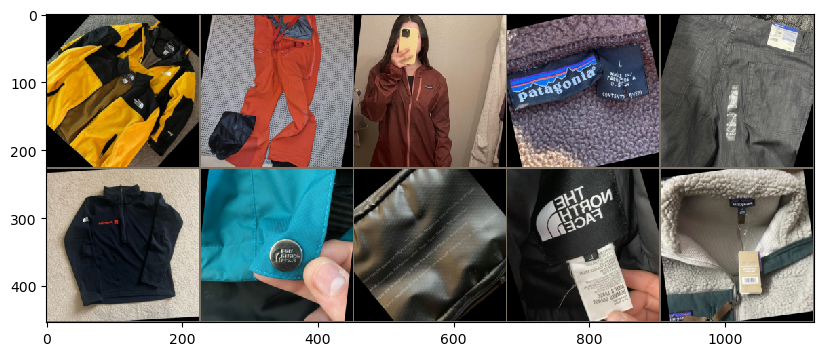

In [4]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

## 3. Model Design Parameters

In this code block, a custom Convolutional Neural Network (CNN) class is defined, which inherits from PyTorch's nn.Module. The network architecture consists of three convolutional layers, each followed by batch normalization and max-pooling layers, and three fully connected layers, with dropout layers placed between them.

During the forward pass, the input tensor is first passed through the convolutional and max-pooling layers, with ReLU activations applied after batch normalization. The tensor is then flattened before being processed by the fully connected layers, with dropout applied after the first two fully connected layers. The final output is generated using the last fully connected layer and a log softmax activation function.

In [5]:
# Define a custom Convolutional Neural Network class inheriting from PyTorch's nn.Module
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the first convolutional layer with batch normalization
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Define the second convolutional layer with batch normalization
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Define the third convolutional layer with batch normalization
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Define the first fully connected layer and dropout layer
        self.fc1 = nn.Linear(28*28*128, 512)
        self.dropout1 = nn.Dropout(0.5)
        
        # Define the second fully connected layer and dropout layer
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        
        # Define the third fully connected layer for the final output
        self.fc3 = nn.Linear(256, 2)

    def forward(self, X):
        # Define the forward pass of the neural network
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        
        # Flatten the tensor before passing it to the fully connected layers
        X = X.view(-1, 28*28*128)
        
        X = F.relu(self.fc1(X))
        X = self.dropout1(X)
        X = F.relu(self.fc2(X))
        X = self.dropout2(X)
        
        # Apply the final fully connected layer and log softmax activation for the output
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)


In this code block, we set up the training of the custom Convolutional Neural Network. First, the random seed is set to ensure reproducibility of the results. Then, the Convolutional Network model is instantiated. Weights for the imbalanced classes are created to handle class imbalance.

The loss function (criterion) is defined using the class weights for imbalanced classes, and the optimizer (Adam) is set with a learning rate of 0.001. Finally, the CNN model architecture is displayed.

In [6]:
# Set the random seed for reproducibility
torch.manual_seed(1)

# Instantiate the Convolutional Network model
CNNmodel = ConvolutionalNetwork()

# Create weights for the imbalanced classes
weights = [1/450, 1/130]
class_weights = torch.FloatTensor(weights)

# Define the loss function (criterion) using the class weights for imbalanced classes
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Define the optimizer (Adam) with learning rate 0.001
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)

# Display the CNN model architecture
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

## 4. Run Model

In this code block, we train the Convolutional Neural Network and evaluate its performance on the test data. The training process is run for 10 epochs, and we limit the number of training and testing batches to 100 each for faster computation.

We initialize lists to store training losses, test losses, training correct predictions, and test correct predictions. For each epoch, we iterate through the training batches, applying the model and computing the loss. We then tally the number of correct predictions and update the model parameters accordingly. Interim results are printed for every 10 batches.

After completing the training batches, we evaluate the model on the test data without updating the model parameters (using torch.no_grad()). We apply the model to the test data and tally the number of correct predictions. Finally, we calculate the test loss and append it to the test_losses list along with test_correct predictions.

At the end of the training process, the total duration of the training is printed.

In [7]:
import time
start_time = time.time()

epochs = 10

max_trn_batch = 100
max_tst_batch = 100

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1

        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/500]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss)
    train_correct.append(trn_corr)

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:  0  batch:   10 [   100/500]  loss: 9.25942516  accuracy:  66.000%
epoch:  0  batch:   20 [   200/500]  loss: 12.12700462  accuracy:  70.500%
epoch:  0  batch:   30 [   300/500]  loss: 2.62205958  accuracy:  72.000%
epoch:  0  batch:   40 [   400/500]  loss: 6.05027771  accuracy:  73.000%
epoch:  0  batch:   50 [   500/500]  loss: 7.06511831  accuracy:  72.400%
epoch:  0  batch:   60 [   600/500]  loss: 0.04230287  accuracy:  72.000%
epoch:  1  batch:   10 [   100/500]  loss: 0.00042296  accuracy:  67.000%
epoch:  1  batch:   20 [   200/500]  loss: 1.47119415  accuracy:  73.000%
epoch:  1  batch:   30 [   300/500]  loss: 1.93575561  accuracy:  74.333%
epoch:  1  batch:   40 [   400/500]  loss: 2.13447022  accuracy:  73.500%
epoch:  1  batch:   50 [   500/500]  loss: 2.32893085  accuracy:  73.400%
epoch:  1  batch:   60 [   600/500]  loss: 1.47180414  accuracy:  73.167%
epoch:  2  batch:   10 [   100/500]  loss: 0.98204577  accuracy:  72.000%
epoch:  2  batch:   20 [   200/500]  

In [8]:
# Save copy of model
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

## 5. Model Evaluation

**A. Model Training Loss**

In this code block, we create a plot to visualize the loss on both the training and validation (test) sets at the end of each epoch. We plot the train_losses and test_losses lists and add appropriate labels for each line. We also set a title for the plot and display the legend to make it easy to interpret the results. This visualization helps us understand how well the model is learning from the data and whether it is overfitting or underfitting.

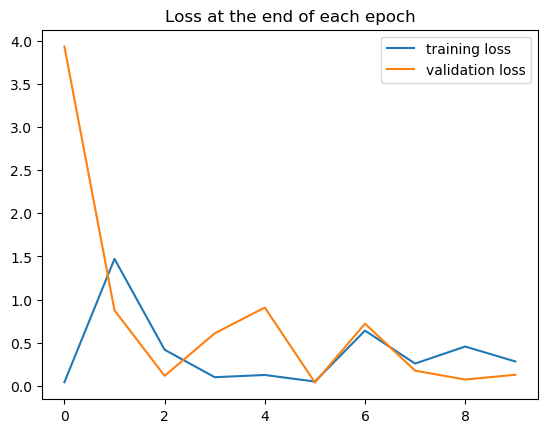

In [9]:
# Plot loss on training and validation sets
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

**B. Model Accuracy/Classification Report**

Print out model accuracy on training data.

In [10]:
# Print test accuracy
print(test_correct)
print(f'Test accuracy: {test_correct[-1].item()*100/len(test_data):.3f}%')

[tensor(276), tensor(346), tensor(384), tensor(385), tensor(387), tensor(387), tensor(384), tensor(385), tensor(387), tensor(388)]
Test accuracy: 87.387%


Print out model classification report on test data.

In [11]:
# Import classification report
from sklearn.metrics import classification_report

# predict y_test based on X_test
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



/home/tom/anaconda3/envs/pytorchenv_gpu/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


Print out model confusion matrix on test data.

In [12]:
from sklearn.metrics import confusion_matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(4).reshape(-1,2))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1]
 [   2    3]]

[[   4]]


In [13]:
# Initialize an empty NumPy array to store the indices of misclassified examples
misses = np.array([])

# Iterate through the predicted and true labels
for i in range(len(predicted.view(-1))):
    # If the predicted label does not match the true label
    if predicted[i] != y_test[i]:
        # Append the index of the misclassified example to the 'misses' array and cast to int64
        misses = np.append(misses, i).astype('int64')

# Display the number of misclassified examples by finding the length of the 'misses' array
len(misses)

0

## 5. Conclusions